In [5]:
!pip install -q rhino3dm shapely trimesh matplotlib pyvista


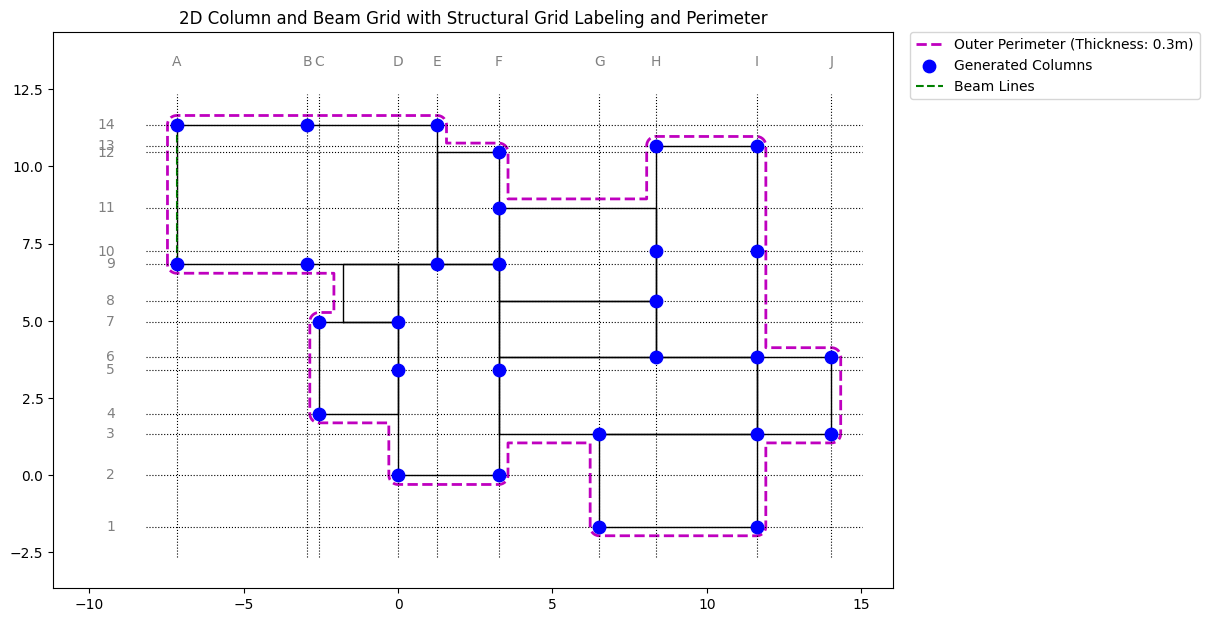

Widget(value='<iframe src="http://localhost:50164/index.html?ui=P_0x1d75dcc7230_0&reconnect=auto" class="pyvis…

In [1]:
#correct oneeeeeeeeeeeeeee

import rhino3dm
import numpy as np
from shapely.geometry import Polygon, Point, MultiPolygon, LineString
import matplotlib.pyplot as plt
import os
import pyvista as pv

# File path
# Note: Using the remembered path from your previous interactions.
rhino_path = r"../Reference Files\rectangles3darchitecturall.3dm"
if not os.path.exists(rhino_path):
    raise FileNotFoundError(f"File not found: {rhino_path}")

# Load model
model = rhino3dm.File3dm.Read(rhino_path)
layers = {layer.Name.lower(): layer.Index for layer in model.Layers}
if 'building' not in layers or ('column' not in layers and 'columns' not in layers):
    raise RuntimeError("Missing required layers: 'building' and 'column' or 'columns'.")

column_layer = 'columns' if 'columns' in layers else 'column'

# Extract building volume & height
building_volumes = []
imported_columns = []
max_z = 0.0 # Global maximum Z for the entire building footprint

wall_breps = []

for obj in model.Objects:
    layer_idx = obj.Attributes.LayerIndex
    geom = obj.Geometry

    if layer_idx == layers['building'] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        bbox = geom.GetBoundingBox()
        base_pts = [
            [bbox.Min.X, bbox.Min.Y],
            [bbox.Max.X, bbox.Min.Y],
            [bbox.Max.X, bbox.Max.Y],
            [bbox.Min.X, bbox.Max.Y],
            [bbox.Min.X, bbox.Max.Y] # Ensure polygon is closed for Shapely
        ]
        poly = Polygon(base_pts)
        building_volumes.append(poly)
        wall_breps.append({'polygon': poly, 'bbox': bbox})
        max_z = max(max_z, bbox.Max.Z) # Update global max_z

    elif layer_idx == layers[column_layer] and geom.ObjectType == rhino3dm.ObjectType.Brep:
        bbox = geom.GetBoundingBox()
        center_x = (bbox.Min.X + bbox.Max.X) / 2
        center_y = (bbox.Min.Y + bbox.Max.Y) / 2
        imported_columns.append((center_x, center_y))

if not building_volumes:
    raise RuntimeError("No valid building geometry found on the 'building' layer.")

# Ask for number of floors
while True:
    try:
        num_floors = int(input("How many floors does the building have? (e.g., 2 for ground + 1 middle + roof): "))
        if num_floors < 1:
            raise ValueError
        break
    except ValueError:
        print("Please enter a valid positive integer for the number of floors.")

# --- Section for perimeter line and wall thickness ---
while True:
    try:
        wall_thickness = float(input("Enter desired wall thickness for the perimeter (e.g., 0.3): "))
        if wall_thickness <= 0:
            raise ValueError
        break
    except ValueError:
        print("Please enter a valid positive number for wall thickness.")

# Combine all building polygons into a single MultiPolygon
combined_building_polygon = MultiPolygon(building_volumes)

# Get the exterior boundary of the combined building and offset it
try:
    exterior_perimeter = combined_building_polygon.buffer(wall_thickness, join_style=1) # join_style=1 for mitered joints
except Exception as e:
    print(f"Could not buffer the building outline. Error: {e}")
    exterior_perimeter = None

# If the buffer operation results in a MultiPolygon, get the largest component
if exterior_perimeter and exterior_perimeter.geom_type == 'MultiPolygon':
    exterior_perimeter = max(exterior_perimeter.geoms, key=lambda p: p.area)

perimeter_line_coords = []
if exterior_perimeter:
    if exterior_perimeter.geom_type == 'Polygon':
        # Extract the exterior ring coordinates
        perimeter_line_coords = list(exterior_perimeter.exterior.coords)
    elif exterior_perimeter.geom_type == 'MultiPolygon':
        # For MultiPolygon, take the exterior of the largest polygon component
        perimeter_line_coords = list(exterior_perimeter.geoms[0].exterior.coords)
    else:
        print("Warning: The buffered perimeter is not a Polygon or MultiPolygon. Cannot extract line coordinates.")

# --- End perimeter section ---

# Room sorting
detected_rooms = sorted([(poly, poly.area) for poly in building_volumes], key=lambda x: -x[1])

# Structural logic
MaxS = 6.0
MinS = 3.0

columns = []
corrected_columns = []
available_imported = imported_columns.copy()
existing_columns = imported_columns.copy()
beams = []

for room_poly, _ in detected_rooms:
    minx, miny, maxx, maxy = room_poly.bounds
    width, height = maxx - minx, maxy - miny
    divisions_x = int(np.ceil(width / MaxS))
    divisions_y = int(np.ceil(height / MaxS))
    x_points = np.linspace(minx, maxx, divisions_x + 1)
    y_points = np.linspace(miny, maxy, divisions_y + 1)
    room_candidates = [(x, y) for x in x_points for y in y_points]

    for col in room_candidates:
        snap = False
        for imp_col in available_imported:
            if np.linalg.norm(np.array(col) - np.array(imp_col)) < MinS:
                corrected_columns.append(col)
                existing_columns.append(col)
                available_imported.remove(imp_col)
                snap = True
                break
        if not snap and all(np.linalg.norm(np.array(col) - np.array(exist_col)) >= MinS for exist_col in existing_columns):
            columns.append(col)
            existing_columns.append(col)

    for x in x_points:
        beams.append(((x, miny), (x, maxy)))
    for y in y_points:
        beams.append(((minx, y), (maxx, y)))

    for corner in list(room_poly.exterior.coords):
        if all(np.linalg.norm(np.array(corner) - np.array(exist_col)) >= MinS * 0.5 for exist_col in existing_columns):
            columns.append(corner)
            existing_columns.append(corner)

# Combine all base columns
all_base_columns = columns + corrected_columns

# --- COLUMN GRID NUMBERING LOGIC ---
# Get unique X and Y coordinates from all generated/snapped columns for grid lines
grid_xs = sorted(list(set([col[0] for col in all_base_columns])))
grid_ys = sorted(list(set([col[1] for col in all_base_columns])))

# Create mapping for X-coordinates to letters (A, B, C...)
x_grid_labels = {x: chr(65 + i) for i, x in enumerate(grid_xs)}
# Create mapping for Y-coordinates to numbers (1, 2, 3...)
y_grid_labels = {y: i + 1 for i, y in enumerate(grid_ys)}

# Determine the actual min/max X/Y of the columns for drawing grid lines
col_min_x_extent = min(col[0] for col in all_base_columns) if all_base_columns else 0
col_max_x_extent = max(col[0] for col in all_base_columns) if all_base_columns else 0
col_min_y_extent = min(col[1] for col in all_base_columns) if all_base_columns else 0
col_max_y_extent = max(col[1] for col in all_base_columns) if all_base_columns else 0

# Add a small buffer to the column extents for drawing grid lines
grid_extent_buffer = 1.0 # Adjusted for better visual spacing
col_min_x_extent -= grid_extent_buffer
col_max_x_extent += grid_extent_buffer
col_min_y_extent -= grid_extent_buffer
col_max_y_extent += grid_extent_buffer

# Determine overall plot limits (consider building outline and grid labels)
# Adjusted limits to provide more space for labels without cutting off the perimeter
# Increased padding for labels
min_x_plot = min(col_min_x_extent, min([coord[0] for coord in perimeter_line_coords] + [col[0] for col in all_base_columns])) - 3.0 if perimeter_line_coords else col_min_x_extent - 3.0
max_x_plot = max(col_max_x_extent, max([coord[0] for coord in perimeter_line_coords] + [col[0] for col in all_base_columns])) + 1.0 if perimeter_line_coords else col_max_x_extent + 1.0
min_y_plot = min(col_min_y_extent, min([coord[1] for coord in perimeter_line_coords] + [col[1] for col in all_base_columns])) - 1.0 if perimeter_line_coords else col_min_y_extent - 1.0
max_y_plot = max(col_max_y_extent, max([coord[1] for coord in perimeter_line_coords] + [col[1] for col in all_base_columns])) + 2.0 if perimeter_line_coords else col_max_y_extent + 2.0


# 2D Visualization
fig, ax = plt.subplots(figsize=(12, 10)) # Increased figure width for legend

# Room outlines
for poly, _ in detected_rooms:
    px, py = poly.exterior.xy
    ax.plot(px, py, 'k-', linewidth=1)

# Plot the new perimeter line
if perimeter_line_coords:
    px_perimeter, py_perimeter = zip(*perimeter_line_coords)
    ax.plot(px_perimeter, py_perimeter, 'm--', linewidth=2, label=f'Outer Perimeter (Thickness: {wall_thickness}m)')

# Plot all columns
gx, gy = zip(*columns)
ax.scatter(gx, gy, c='blue', s=80, label='Generated Columns', zorder=5)

# Snapped imported columns
if corrected_columns:
    cx, cy = zip(*corrected_columns)
    ax.scatter(cx, cy, c='purple', s=80, label='Snapped Imported Columns', zorder=7)

# Original imported columns
if imported_columns:
    ix, iy = zip(*imported_columns)
    ax.scatter(ix, iy, c='red', s=80, label='Original Imported Columns', zorder=10)

# Only draw one label for beam lines in 2D
if beams:
    x1, y1 = beams[0][0]
    x2, y2 = beams[0][1]
    ax.plot([x1, x2], [y1, y2], color='green', linestyle='--', linewidth=1.5, label='Beam Lines')

# Draw and label grid lines
# Increased offset for labels for better clarity
for x_coord in grid_xs:
    ax.plot([x_coord, x_coord], [col_min_y_extent, col_max_y_extent], 'k:', linewidth=0.8) # Dashed vertical grid line
    ax.text(x_coord, col_max_y_extent + 0.8, x_grid_labels[x_coord], ha='center', va='bottom', fontsize=10, color='gray') # Label at top

for y_coord in grid_ys:
    ax.plot([col_min_x_extent, col_max_x_extent], [y_coord, y_coord], 'k:', linewidth=0.8) # Dashed horizontal grid line
    ax.text(col_min_x_extent - 1.0, y_coord, y_grid_labels[y_coord], ha='right', va='center', fontsize=10, color='gray') # Label on left


ax.set_aspect('equal', 'box')
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.) # Moved legend
plt.title("2D Column and Beam Grid with Structural Grid Labeling and Perimeter")

# Using subplots_adjust for explicit margin control instead of tight_layout
# This gives more precise control over the margins for labels
plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.1) # Adjusted values for left and top margin


ax.set_xlim(min_x_plot, max_x_plot)
ax.set_ylim(min_y_plot, max_y_plot)
plt.show()

# PyVista 3D visualization
plotter = pv.Plotter(title="3D Structural System")

# Define sizes for structural elements (now dimensions for rectangular prisms)
column_width = 0.3
column_depth = 0.3

beam_width = 0.25
beam_depth = 0.35

slab_thickness = 0.20

slab_extension_buffer = max(column_width, column_depth) / 2 + 0.05

# Calculate story heights per room, since rooms might have different max Z
room_story_heights = {}
for room_poly, _ in detected_rooms:
    room_specific_max_z = 0.0
    for wall_data in wall_breps:
        if wall_data['polygon'].equals(room_poly):
            room_specific_max_z = wall_data['bbox'].Max.Z
            break
    if room_specific_max_z == 0.0:
        room_specific_max_z = max_z
    
    num_vertical_sections = num_floors 

    if num_vertical_sections > 0:
        story_height = room_specific_max_z / num_vertical_sections
    else:
        story_height = room_specific_max_z
    
    room_story_heights[room_poly.wkt] = story_height


# --- Define Z-levels for each floor in a more structured way ---
floor_z_levels = {} 
for room_poly, _ in detected_rooms:
    room_specific_max_z = 0.0
    for wall_data in wall_breps:
        if wall_data['polygon'].equals(room_poly):
            room_specific_max_z = wall_data['bbox'].Max.Z
            break
    if room_specific_max_z == 0.0:
        room_specific_max_z = max_z

    current_room_floor_z = []
    
    # Slab 0: Ground Slab
    current_room_floor_z.append((0.0, slab_thickness))

    if num_floors > 0: # Only generate intermediate and roof slabs if there's at least 1 floor
        story_height = room_story_heights.get(room_poly.wkt, max_z)
        
        # Intermediate Slabs (from 1 to num_floors-1)
        for i in range(1, num_floors): 
            slab_base_z = i * story_height
            slab_top_z = slab_base_z + slab_thickness

            if slab_top_z > room_specific_max_z + 1e-6:
                slab_top_z = room_specific_max_z
                slab_base_z = max(slab_base_z, slab_top_z - slab_thickness)

            if slab_top_z - slab_base_z < 1e-6:
                continue
                
            current_room_floor_z.append((slab_base_z, slab_top_z))
        
        # Last Slab: Roof Slab
        roof_slab_top_z = room_specific_max_z 
        roof_slab_base_z = roof_slab_top_z - slab_thickness
        
        if current_room_floor_z:
            last_slab_top = current_room_floor_z[-1][1]
            if roof_slab_base_z < last_slab_top + 1e-6:
                roof_slab_base_z = last_slab_top
                roof_slab_top_z = roof_slab_base_z + slab_thickness
                if roof_slab_top_z > room_specific_max_z + 1e-6:
                    roof_slab_top_z = room_specific_max_z
                    roof_slab_base_z = max(roof_slab_top_z - slab_thickness, last_slab_top)
        
        if roof_slab_top_z - roof_slab_base_z < 1e-6:
            pass
        else:
            current_room_floor_z.append((roof_slab_base_z, roof_slab_top_z))

    floor_z_levels[room_poly.wkt] = current_room_floor_z

# --- Add Slabs ---
for room_poly, _ in detected_rooms:
    room_floor_data = floor_z_levels.get(room_poly.wkt, [])
    if not room_floor_data:
        continue

    extended_room_poly = room_poly.buffer(slab_extension_buffer)
    
    for i, (slab_base_z, slab_top_z) in enumerate(room_floor_data):
        current_slab_thickness = slab_top_z - slab_base_z
        if current_slab_thickness < 1e-6:
            continue

        points_3d_for_slab_base = []
        poly_coords = list(extended_room_poly.exterior.coords)
        if poly_coords[0] != poly_coords[-1]:
            poly_coords.append(poly_coords[0])
            
        for x, y in poly_coords:
            points_3d_for_slab_base.append([x, y, 0.0])
        
        points_3d_for_slab_base = np.array(points_3d_for_slab_base)

        if len(points_3d_for_slab_base) < 3:
            continue

        slab_base_mesh = pv.PolyData(points_3d_for_slab_base)
        
        try:
            triangulated_faces = slab_base_mesh.delaunay_2d().faces
            if triangulated_faces is None or len(triangulated_faces) == 0:
                continue
            slab_base_mesh = pv.PolyData(points_3d_for_slab_base, faces=triangulated_faces)
        except Exception as e:
            print(f"Delaunay triangulation failed for a slab base ({room_poly.bounds}): {e}. Skipping slab.")
            continue

        slab_mesh = slab_base_mesh.extrude(vector=(0, 0, current_slab_thickness), capping=True)
        slab_mesh = slab_mesh.translate((0, 0, slab_base_z))
        
        plotter.add_mesh(slab_mesh, color='sienna', opacity=0.8, smooth_shading=True)


# --- Add Columns ---
for x, y in all_base_columns:
    column_room_wkt = None
    for room_poly, _ in detected_rooms:
        if Point(x, y).within(room_poly):
            column_room_wkt = room_poly.wkt
            break
    if column_room_wkt is None:
        min_dist = float('inf')
        for room_poly, _ in detected_rooms:
            dist = Point(x,y).distance(room_poly)
            if dist < min_dist:
                min_dist = dist
                column_room_wkt = room_poly.wkt
        if column_room_wkt is None:
             continue

    room_floor_data = floor_z_levels.get(column_room_wkt, [])
    if not room_floor_data or len(room_floor_data) <= 1:
        continue
    
    num_slabs_in_room = len(room_floor_data)
    
    for i in range(num_slabs_in_room - 1):
        col_base_z = room_floor_data[i][1] 
        col_top_z = room_floor_data[i+1][0] 

        if col_top_z <= col_base_z + 1e-6:
            continue

        col_min_x = x - column_width / 2
        col_max_x = x + column_width / 2
        col_min_y = y - column_depth / 2
        col_max_y = y + column_depth / 2
        
        column_box = pv.Box([col_min_x, col_max_x, col_min_y, col_max_y, col_base_z, col_top_z])
        plotter.add_mesh(column_box, color='blue', smooth_shading=True)


# --- Add Beams ---
for (x1, y1), (x2, y2) in beams:
    full_beam_line = LineString([(x1, y1), (x2, y2)])

    for i in range(len(room_floor_data)):
        relevant_rooms_for_this_floor = []
        for room_poly, _ in detected_rooms:
            if room_poly.intersects(full_beam_line.buffer(1e-3)):
                room_floor_data_current_room = floor_z_levels.get(room_poly.wkt, [])
                if len(room_floor_data_current_room) > i:
                    slab_base_z_for_this_room_floor = room_floor_data_current_room[i][0]
                    slab_top_z_for_this_room_floor = room_floor_data_current_room[i][1]

                    room_specific_max_z = 0.0
                    for wall_data in wall_breps:
                        if wall_data['polygon'].equals(room_poly):
                            room_specific_max_z = wall_data['bbox'].Max.Z
                            break
                    if room_specific_max_z == 0.0: room_specific_max_z = max_z

                    if slab_base_z_for_this_room_floor >= room_specific_max_z - 1e-6 and i < len(room_floor_data_current_room) -1:
                        continue 
                    
                    relevant_rooms_for_this_floor.append((room_poly, slab_base_z_for_this_room_floor))

        if not relevant_rooms_for_this_floor:
            continue

        for room_poly, slab_base_z_for_current_room in relevant_rooms_for_this_floor:
            intersection = full_beam_line.intersection(room_poly)

            if intersection.geom_type == 'LineString':
                segments_to_draw = [intersection]
            elif intersection.geom_type == 'MultiLineString':
                segments_to_draw = list(intersection.geoms)
            else: 
                continue

            for segment in segments_to_draw:
                if not segment.is_empty and segment.length > 1e-6:
                    seg_x1, seg_y1 = segment.coords[0]
                    seg_x2, seg_y2 = segment.coords[-1]

                    beam_top_z = slab_base_z_for_current_room
                    beam_base_z = beam_top_z - beam_depth

                    if beam_base_z < 0:
                        beam_base_z = 0
                        if beam_top_z <= 0:
                            continue
                    
                    if beam_top_z <= beam_base_z + 1e-6:
                        continue

                    if abs(seg_x1 - seg_x2) > abs(seg_y1 - seg_y2):
                        beam_min_x = min(seg_x1, seg_x2)
                        beam_max_x = max(seg_x1, seg_x2)
                        beam_center_y = (seg_y1 + seg_y2) / 2
                        beam_min_y = beam_center_y - beam_width / 2
                        beam_max_y = beam_center_y + beam_width / 2
                    else:
                        beam_min_y = min(seg_y1, seg_y2)
                        beam_max_y = max(seg_y1, seg_y2)
                        beam_center_x = (seg_x1 + seg_x2) / 2
                        beam_min_x = beam_center_x - beam_width / 2
                        beam_max_x = beam_center_x + beam_width / 2

                    beam_box = pv.Box([beam_min_x, beam_max_x, beam_min_y, beam_max_y, beam_base_z, beam_top_z])

                    is_roof_slab = (i == len(room_floor_data_current_room) - 1)
                    color = 'green' if is_roof_slab else 'orange' 
                    plotter.add_mesh(beam_box, color=color, smooth_shading=True)


# Actual Brep-based walls visualization (semi-transparent)
def mesh_brep(brep, mesh_type=rhino3dm.MeshType.Any):
    meshes = []
    for face in brep.Faces:
        try:
            m = face.GetMesh(mesh_type)
            if m: meshes.append(m)
        except:
            continue
    return meshes

for obj in model.Objects:
    geom = obj.Geometry
    layer_idx = obj.Attributes.LayerIndex
    if layer_idx == layers['building'] and isinstance(geom, rhino3dm.Brep):
        meshes = mesh_brep(geom)
        for mesh in meshes:
            pts = [(v.X, v.Y, v.Z) for v in mesh.Vertices]
            faces = []
            for f in mesh.Faces:
                if len(f) == 4:
                    idxs = (f[0], f[1], f[2], f[3])
                else:
                    idxs = (f[0], f[1], f[2])
                faces.append((len(idxs),) + idxs)
            faces_flat = [i for face in faces for i in face]
            pv_mesh = pv.PolyData(pts, faces_flat)
            plotter.add_mesh(pv_mesh, color='lightgray', opacity=0.3)

plotter.show_grid()
plotter.show()

In [2]:
import pandas as pd
from collections import OrderedDict

# --- 1. Collect Unique Nodes ---
node_coords = []
node_dict = OrderedDict()
node_counter = 0

def add_node(pt):
    key = tuple(np.round(pt, 5))  # reduce float precision issues
    if key not in node_dict:
        node_id = f"N{len(node_dict)}"
        node_dict[key] = node_id
        node_coords.append([node_id] + list(key))
    return node_dict[key]

# --- 2. Create Column & Beam Connections ---
column_lines = []
beam_lines = []

for x, y in all_base_columns:
    btm = (x, y, 0)
    top = (x, y, max_z)
    id_btm = add_node(btm)
    id_top = add_node(top)
    column_lines.append((id_btm, id_top))

for (x1, y1), (x2, y2) in beams:
    pt1 = (x1, y1, max_z)
    pt2 = (x2, y2, max_z)
    id1 = add_node(pt1)
    id2 = add_node(pt2)
    beam_lines.append((id1, id2))

# --- 3. Export nodes.csv ---
df_nodes = pd.DataFrame(node_coords, columns=["ID", "X", "Y", "Z"])
df_nodes.to_csv("nodes4.csv", index=False)
print("✅ nodes.csv written.")

# --- 4. Export columns.csv ---
col_data = []
for i, (i_node, j_node) in enumerate(column_lines):
    p1 = df_nodes[df_nodes["ID"] == i_node][["X", "Y", "Z"]].values[0]
    p2 = df_nodes[df_nodes["ID"] == j_node][["X", "Y", "Z"]].values[0]
    length = np.linalg.norm(p2 - p1)
    col_data.append([f"C{i}", i_node, j_node, round(length, 3)])

df_cols = pd.DataFrame(col_data, columns=["ID", "i_node", "j_node", "length"])
df_cols.to_csv("columns4.csv", index=False)
print("✅ columns.csv written.")

# --- 5. Export beams.csv ---
beam_data = []
for i, (i_node, j_node) in enumerate(beam_lines):
    p1 = df_nodes[df_nodes["ID"] == i_node][["X", "Y", "Z"]].values[0]
    p2 = df_nodes[df_nodes["ID"] == j_node][["X", "Y", "Z"]].values[0]
    length = np.linalg.norm(p2 - p1)
    beam_data.append([f"B{i}", i_node, j_node, round(length, 3)])

df_beams = pd.DataFrame(beam_data, columns=["ID", "i_node", "j_node", "length"])
df_beams.to_csv("beams4.csv", index=False)
print("✅ beams.csv written.")


✅ nodes.csv written.
✅ columns.csv written.
✅ beams.csv written.
